In [1]:
import pandas as pd
import pickle
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow import keras


year='2019'
total_df = pd.read_csv('./src/data/dust_'+year+'.csv')

## EDA

In [2]:
total_df.head(3)

,Unnamed: 0,MSRDT_DE,MSRRGN_NM,MSRSTE_NM,PM10,PM25,O3,NO2,CO,SO2
0,0,20190101,도심권,중구,38.0,26.0,0.019,0.032,0.6,0.003
1,1,20190101,도심권,종로구,35.0,22.0,0.016,0.033,0.7,0.004
2,2,20190101,도심권,용산구,31.0,25.0,0.013,0.033,0.6,0.003


In [3]:
total_df.describe()

,Unnamed: 0,MSRDT_DE,PM10,PM25,O3,NO2,CO,SO2
count,8946.000000,8.946000e+03,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000
mean,11.994634,2.019068e+07,40.861055,24.335345,0.025025,0.026945,0.512464,0.003857
std,7.208651,3.446862e+02,27.457152,18.836681,0.013961,0.013103,0.231364,0.001419
min,0.000000,2.019010e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,2.019041e+07,23.000000,13.000000,0.014000,0.017000,0.400000,0.003000
50%,12.000000,2.019070e+07,35.000000,20.000000,0.024000,0.025000,0.500000,0.004000
75%,18.000000,2.019100e+07,51.000000,30.000000,0.035000,0.036000,0.600000,0.005000
max,24.000000,2.019123e+07,240.000000,155.000000,0.088000,0.080000,1.900000,0.012000


In [4]:
total_df.corr()

,Unnamed: 0,MSRDT_DE,PM10,PM25,O3,NO2,CO,SO2
Unnamed: 0,1.000000,-0.000936,0.046662,0.035748,-0.047753,0.065022,-0.178870,0.035999
MSRDT_DE,-0.000936,1.000000,-0.397410,-0.357238,-0.183525,-0.204867,-0.218219,-0.422283
PM10,0.046662,-0.397410,1.000000,0.902611,0.016442,0.576541,0.612297,0.444610
PM25,0.035748,-0.357238,0.902611,1.000000,0.024517,0.566740,0.625629,0.440845
O3,-0.047753,-0.183525,0.016442,0.024517,1.000000,-0.343200,-0.252219,0.092254
NO2,0.065022,-0.204867,0.576541,0.566740,-0.343200,1.000000,0.687978,0.428213
CO,-0.178870,-0.218219,0.612297,0.625629,-0.252219,0.687978,1.000000,0.427551
SO2,0.035999,-0.422283,0.444610,0.440845,0.092254,0.428213,0.427551,1.000000


### 서로 상관계수가 높은 변수들이고, 해당 과제에서 input 값이 명백히 정해져 있는 것이 아니다.

### 그렇다면 간단하게 각 자치구 별로 PM10을 시계열 모델로 예측하여, 그 이후 날짜를 입력받으면 해당 날짜의 미세먼지 농도를 예측하는 방향으로 접근하자

In [5]:
total_df.drop(['PM25','O3','NO2','CO','SO2'], axis=1, inplace=True)

In [6]:
total_df.sort_values(['MSRSTE_NM','MSRDT_DE'], inplace=True)

In [7]:
region_list =list(total_df['MSRSTE_NM'].unique())

In [ ]:
region_dict = {
	'종로구' : 'Jongno',
	'중구' : 'Jung',
	'용산구' : 'Yongsan',
	'성동구' : 'Seongdong',
	'광진구' : 'Gwangjin',
	'동대문구' : 'Dongdaemun',
	'중랑구' : 'Jungnang',
	'성북구' : 'Seongbuk',
	'강북구' : 'Gangbuk',
	'도봉구' : 'Dobong',
	'노원구' : 'Nowon',
	'은평구' : 'Eunpyeong',
	'서대문구' : 'Seodaemun',
	'마포구' : 'Mapo',
	'양천구' : 'Yangcheon',
	'강서구' : 'Gangseo',
	'구로구' : 'Guro',
	'금천구' : 'Geumcheon',
	'영등포구' : 'Yeongdeungpo',
	'동작구' : 'Dongjak',
	'관악구' : 'Gwanak',
	'서초구' : 'Seocho',
	'강남구' : 'Gangnam',
	'송파구' : 'Songpa',
	'강동구' : 'Gangdong'
}

In [8]:
def train_val_split(time, series, time_step):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [9]:
window_size = 15
batch_size = 100
shuffle_buffer_size = 30

earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=20
    )

for i in region_list:
  temp_df = total_df.loc[total_df['MSRSTE_NM']==i]
  temp_time = np.array(temp_df.reset_index().index)
  temp_series = np.array(temp_df['PM10'])
  split_time = int(len(temp_df)*0.8)

  time_train, series_train, time_valid, series_valid = train_val_split(temp_time, temp_series, split_time)

  train_set = windowed_dataset(series_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
  valid_set = windowed_dataset(series_valid, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)  
  tf.keras.backend.clear_session()
  tf.random.set_seed(51)
  np.random.seed(51)

  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    tf.keras.layers.LSTM(90, return_sequences=True),
    tf.keras.layers.LSTM(90),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
  ])


  optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
  model.compile(loss=tf.keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])
  history = model.fit(train_set,
                      validation_data = valid_set,
                      epochs=150,
                      callbacks=[earlystopping])
  
  model.save(year+'_'+region_dict[i]+'.h5')

Epoch 1/150
3/3 [==============================] - 11s 1s/step - loss: 79.8716 - mae: 80.3715 - val_loss: 19.5055 - val_mae: 19.9908
Epoch 2/150
3/3 [==============================] - 0s 57ms/step - loss: 24.1303 - mae: 24.6262 - val_loss: 11.6086 - val_mae: 12.1085
Epoch 3/150
3/3 [==============================] - 0s 69ms/step - loss: 16.0192 - mae: 16.5105 - val_loss: 22.4660 - val_mae: 22.9660
Epoch 4/150
3/3 [==============================] - 0s 43ms/step - loss: 18.5743 - mae: 19.0726 - val_loss: 12.5493 - val_mae: 13.0479
Epoch 5/150
3/3 [==============================] - 0s 64ms/step - loss: 15.8888 - mae: 16.3816 - val_loss: 12.1902 - val_mae: 12.6847
Epoch 6/150
3/3 [==============================] - 0s 62ms/step - loss: 13.8033 - mae: 14.2951 - val_loss: 12.2554 - val_mae: 12.7388
Epoch 7/150
3/3 [==============================] - 0s 48ms/step - loss: 14.2117 - mae: 14.7025 - val_loss: 11.8166 - val_mae: 12.3025
Epoch 8/150
3/3 [==============================] - 0s 59ms/step

In [10]:
import matplotlib.pyplot as plt


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

11/11 [==============================] - 1s 10ms/step


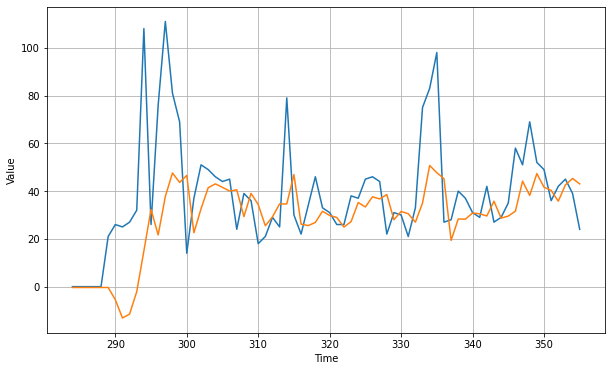

In [11]:
rnn_forecast = model_forecast(model, temp_series, window_size).squeeze()
rnn_forecast = rnn_forecast[split_time - window_size:-1]


plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
mse, mae = compute_metrics(series_valid, rnn_forecast)
print(f"mse: {mse}, mae: {mae} for forecast")

mse: 535.8865966796875, mae: 15.045037269592285 for forecast
